In [1]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [2]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

## דוגמה מסכמת 
נשתמש בעקומות דעיכה אקספוננציאליות כדי להדגים **שימושי Matplotlib מתקדמים**:  
סולמות לוגריתמיים, טיקים ותוויות עם יחידות, מקרא ו־annotations, **ציר תאום** ליחידות חלופיות, **Colormap** עם Colorbar, ושמירה לקובץ.  

`````{admonition} פיזיקלית, המודל יכול לייצג מגוון תהליכים דומים:
:class :tip
- **קירור ניוטוני**: גוף חם בטמפרטורה $T_0$ מתקרר אל טמפרטורת סביבה $T_{\rm amb}$ על פי  

  $$
  T(t) = T_{\rm amb} + (T_0 - T_{\rm amb}) e^{-t/\tau}
  $$
  
- **פריקת קבל במעגל RC**: המתח דועך לפי $V(t)=V_0 e^{-t/RC}$.
- **דעיכת רדיואקטיביות**: מספר גרעינים $N(t)=N_0 e^{-\lambda t}$.

כל אלה חולקים את הצורה המתמטית של דעיכה אקספוננציאלית עם קבוע זמן $\tau$. 
`````

ראשית, נייבא את הספריות והפונקציות בהן נשתמש:


In [3]:
# Core imports for all functions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps


### 1) יצירת נתונים
בקטע מוגדרות שתי פונקציות עזר פשוטות:

1. **`()make_data`**  
   - מחזירה את פרמטרי הבעיה:  
     - `T_amb` — טמפרטורת סביבה (293.15 K ≈ 20°C).  
     - `T0` — טמפרטורה התחלתית (373.15 K ≈ 100°C).  
     - `taus` — מערך של קבועי זמן אופייניים [שניות] (0.5, 2, 10, 50).  
   - בנוסף יוצרת מערך זמנים `t` הנפרס על פני **חמישה סדרי גודל** (מ־0.01 עד 1000 שניות), באמצעות `np.logspace`, כך שנוכל לעבוד בקלות עם סולם לוגריתמי בציר ה־x.

2. **`model_T(t, tau, T_amb, T0)`**  
   - מחשבת את פונקציית הדעיכה האקספוננציאלית:  

     $$
     T(t) = T_{\rm amb} + (T_0 - T_{\rm amb}) \, e^{-t/\tau}
     $$  
     
   - זוהי הצורה הכללית של מודלים כמו קירור ניוטוני, פריקת קבל במעגל RC או דעיכה רדיואקטיבית.  
   - הפונקציה מקבלת וקטור זמנים `t`, קבוע זמן `tau`, ואת הפרמטרים הפיזיקליים, ומחזירה את הערכים של $T(t)$.

בקצרה: **`make_data` מגדירה נתוני התחלה ורשת זמנים לוגריתמית, ו־`model_T` מחזירה את פתרון הדעיכה עבורם.**


In [4]:
def make_data():
    """Create parameters and a log-spaced time grid."""
    T_amb = 293.15                 # K (ambient, ~20°C)
    T0    = 373.15                 # K (initial, ~100°C)
    taus  = np.array([0.5, 2.0, 10.0, 50.0])  # s (span decades)
    t     = np.logspace(-2, 3, 800)          # log grid for x-scale
    return T_amb, T0, taus, t

def model_T(t, tau, T_amb, T0):
    """Exponential decay model: T(t)=T_amb + (T0-T_amb)*exp(-t/tau)."""
    return T_amb + (T0 - T_amb)*np.exp(-t/tau)


### 2) הכנה ל־Colormap
בקטע מוגדרת הפונקציה **`prepare_colormap(taus, cmap_name="viridis")`** שמטרתה להכין מפת צבעים לשימוש עקבי בגרפים:

- **`Normalize`**  
  - אובייקט מ־Matplotlib שממיר ערכים נומריים (כאן: ערכי $\tau$) לסולם $[0,1]$.  
  - ההגדרה `vmin=np.min(taus), vmax=np.max(taus)` מבטיחה שהערך הקטן ביותר של $\tau$ יתאים לתחילת הסקאלה (0), והגדול ביותר לסופה (1).  
  - זה מאפשר למפות את כל ערכי $\tau$ בצורה פרופורציונלית לצבעים.

- **`colormaps.get_cmap(cmap_name)`**  
  - הפונקציה המומלצת כיום (במקום `get_cmap`, שהוצאה משימוש) להחזרת מפת הצבעים המבוקשת.  
  - ברירת המחדל `"viridis"` היא אחת מהמפות המומלצות להצגה מדעית, עם מעבר חלק וברור של צבעים.

- הפונקציה מחזירה זוג: `(norm, cmap)`  
  - ניתן להשתמש ב־`cmap(norm(tau))` כדי לקבל צבע עקבי עבור כל ערך $\tau$.

בקצרה: הפונקציה **מכינה מנגנון שמתרגם ערכי $\tau$ לצבעים בהתאם למפת צבעים מדעית (כמו viridis)**, וכך כל גרף יהיה עקבי וברור מבחינה ויזואלית.


In [5]:
def prepare_colormap(taus, cmap_name="viridis"):
    """Return a Normalize and Colormap for consistent color coding by tau."""
    norm = Normalize(vmin=float(np.min(taus)), vmax=float(np.max(taus)))
    cmap = colormaps.get_cmap(cmap_name)  # new recommended syntax
    return norm, cmap

### 3) ציור הלוח העליון + סולם לוגריתמי בציר $x$
בקטע מוגדרת הפונקציה **`(...)plot_top_panel`**, שאחראית לצייר את התרשים העליון עם כל ההגדרות המתקדמות של Matplotlib:

1. **לולאת ציור העקומות**  
   - לכל ערך $\tau$ מחשבים את $T(t)$ באמצעות `model_T`.  
   - מציירים עם `(...)ax.plot` כאשר הצבע נקבע לפי `cmap(norm(tau))`, כלומר ערך $\tau$ מתורגם לצבע במפה.  
   - מוסיפים `label` כך שהעקומה תופיע במקרא עם הערך המתאים של $\tau$.

2. **סולם לוגריתמי בציר $x$**  
   - `ax.set_xscale("log")` הופך את ציר הזמן ללוגריתמי, שימושי להצגת תהליכים על פני סדרי גודל שונים.

3. **תוויות לצירים עם יחידות**  
   - `ax.set_xlabel(r"$t$ (s)")` ו־`ax.set_ylabel(r"$T$ (K)")` מציינים את המשתנה והיחידות.

4. **ticks ותוויות מדעיות**  
   - `ax.ticklabel_format(axis="y", style="sci", scilimits=(-2,2), useMathText=True)` מציג את המספרים בציר $y$ בסגנון מדעי (חזקת 10), עם תחום שבו זה נכפה.

5. **התאמות נוספות לticks**  
   - `(...)ax.tick_params` קובע סגנון טיקים אחיד (כלפי פנים, גם בצירים עליונים וימניים).

6. **רשת גרף (grid)**  
   - `ax.grid(True, which="both", linestyle="-", alpha=0.2)` מוסיף רשת עדינה גם לטיקים משניים, מה שמקל על קריאת ערכים.

7. **מקרא (legend)**  
   - `(...)ax.legend` יוצר מקרא עם כותרת "Cooling curves", המציג איזו עקומה מתאימה לאיזה $\tau$.

8. **כותרת לגרף**  
   - `(...)ax.set_title` נותן כותרת ברורה שמסבירה שזהו תרשים להדגמת שימושים מתקדמים ב־Matplotlib.

בקצרה: הפונקציה מציירת את עקומות הקירור $T(t)$ עבור ערכי $\tau$ שונים, ומדגימה **שילוב של סולם לוגריתמי, טיקים מדעיים, מקרא, רשת וכותרות** — כלומר את רוב פיצ'רי הבסיס המתקדמים של Matplotlib.


In [6]:
def plot_top_panel(ax, t, taus, T_amb, T0, norm, cmap):
    """Plot T(t) curves with log x-scale, scientific ticks, and legend."""
    for tau in taus:
        T = model_T(t, tau, T_amb, T0)
        ax.plot(t, T, color=cmap(norm(tau)),
                label=rf"$\tau={tau:g}\,\mathrm{{s}}$")  # plot() with label for legend
    
    ax.set_xscale("log")                  # <- log scale on x
    ax.set_xlabel(r"$t$ (s)")             # <- axis label with units
    ax.set_ylabel(r"$T$ (K)")
    
    ax.ticklabel_format(axis="y", style="sci", scilimits=(-2, 2), useMathText=True)  # scientific y
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)  # tidy ticks
    ax.grid(True, which="both", linestyle="-", alpha=0.2)                            # grid for both
    ax.legend(title="Cooling curves", loc="upper right")                             # legend
    
    ax.set_title("Matplotlib advanced features on exponential cooling")

### 4) הוספת Annotation לנקודת חצי־זמן
בקטע מוגדרת הפונקציה **`(...)add_annotation`**, שמטרתה להדגיש נקודה פיזיקלית חשובה על הגרף באמצעות כלי ה־annotation של Matplotlib:

1. **חישוב נקודת חצי־זמן**  
   - $t_{1/2} = \tau \ln 2$ — הזמן שבו הטמפרטורה ירדה בדיוק למחצית הדרך בין $T_0$ ל־$T_{\rm amb}$.  
   - $T_{1/2} = T_{\rm amb} + \tfrac{1}{2}(T_0 - T_{\rm amb})$ — הערך של הטמפרטורה באותו זמן.

2. **סימון הנקודה בגרף**  
   - `(...)ax.plot` מצייר נקודה אדומה קטנה (`"o"`) במיקום $(t_{1/2}, T_{1/2})$.

3. **קו עזר אנכי**  
   - `(...)ax.axvline` מוסיף קו אנכי מקווקו באותו $t_{1/2}$ כדי להדגיש את הזמן הזה על כל התרשים.

4. **הוספת הערה (Annotation)**  
   - `(...)ax.annotate` מציב טקסט "half-time" ליד הנקודה, עם חץ המצביע עליה.  
   - הפרמטרים `xy`, `xytext`, `arrowprops` שולטים על מיקום החץ, מיקום הטקסט, וסגנון החץ.

בקצרה: הפונקציה מוסיפה **סימון נקודתי, קו עזר וטקסט עם חץ** כדי להמחיש בצורה ברורה את מושג ה־**חצי־זמן** על הגרף.


In [7]:
def add_annotation(ax, T_amb, T0, tau_sel=2.0):
    """Add an annotation for the half-time point t_half = tau*ln(2)."""
    t_half = tau_sel*np.log(2.0)
    T_half = T_amb + 0.5*(T0 - T_amb)
    ax.plot(t_half, T_half, "o", color="crimson", ms=6)   # marker at the point
    ax.axvline(t_half, color="crimson", lw=1, ls="--", alpha=0.6)  # helper line
    ax.annotate("half-time",                               # annotate() with arrow
                xy=(t_half, T_half),
                xytext=(12, T_half + 8),
                textcoords="data",
                arrowprops=dict(arrowstyle="->", lw=1.2))


### 5) ציר תאום ליחידות חלופיות (K ↔ °C)
בקטע מוגדרת הפונקציה **`add_twin_axis_celsius(ax)`**, שמטרתה להוסיף **ציר $y$ ימני** שבו הערכים מוצגים במעלות צלזיוס (°C), בהתאמה לציר השמאלי שמוצג בקלווין (K).

1. **יצירת ציר תאום**  
   - `()ax.twinx` יוצר ציר חדש שמשתף את אותו ציר $x$ אך מאפשר תוויות שונות בציר $y$ הימני.  
   - מגדירים את התווית שלו כ־"$T$ (°C)".

2. **יישור תחומי הציר**  
   - קוראים את תחום הערכים של הציר השמאלי (`()y0, y1 = ax.get_ylim`).  
   - מגדירים את הציר הימני כך שיתחיל מ־`y0 - 273.15` ועד `y1 - 273.15`, כלומר הזזה של כל הטווח ממעלות קלווין ל־°C.  
   - כך מבטיחים ששני הצירים מציגים את אותו גרף, אבל ביחידות שונות.

3. **סנכרון הטיקים**  
   - לוקחים את רשימת הטיקים מהציר השמאלי (`()ax.get_yticks`).  
   - קובעים טיקים בצד ימין באותן נקודות ויזואליות, אך עם ערכים מומרות ל־°C.  
   - לדוגמה: אם בצד שמאל מופיע `300 K`, בצד ימין יופיע `26.9 °C` בדיוק באותו גובה.

4. **ניקיון גרפי**  
   - מכבים את ה־grid בצד הימני (`ax2.grid(False)`), כדי למנוע רשת כפולה.  
   - קובעים שטיקים פונים פנימה (`ax2.tick_params(direction="in")`) כדי להבדיל מציר שמאל.

5. **החזרת הציר**  
   - מחזירים את הציר הימני (`ax2`) כדי שניתן יהיה להמשיך לעבוד עליו אם צריך.

בקצרה: הפונקציה יוצרת **ציר תאום בצד ימין** עם יחידות צלזיוס, מיושר ומסונכרן עם הציר השמאלי בקלווין, כך שהקורא יכול לקרוא את הגרף בשתי מערכות יחידות במקביל.



In [8]:
def add_twin_axis_celsius(ax):
    """Add a right y-axis in °C aligned with the left y-axis in K."""
    ax2 = ax.twinx()                          # create a twin y-axis
    ax2.set_ylabel(r"$T$ (°C)")
    
    # Align y-limits so ticks match line-by-line
    y0, y1 = ax.get_ylim()
    ax2.set_ylim(y0 - 273.15, y1 - 273.15)    # same visual positions
    
    # Copy left ticks and show converted labels on the right
    left_ticks = ax.get_yticks()
    ax2.set_yticks(left_ticks - 273.15)       # place ticks at matching heights
    ax2.set_yticklabels([f"{v-273.15:.1f}" for v in left_ticks])
    
    ax2.grid(False)                            # keep grid only on left
    ax2.tick_params(direction="in")
    return ax2


### 6) הוספת Colorbar
בקטע מוגדרת הפונקציה **`add_colorbar(fig, ax, norm, cmap)`**, שמטרתה להוסיף **סרגל צבעים (Colorbar)** לגרף — כדי להסביר איך הצבעים משויכים לערכים של קבוע הזמן $\tau$.

1. **יצירת `ScalarMappable`**  
   - `ScalarMappable(norm=norm, cmap=cmap)` יוצר אובייקט שמתרגם ערכים נומריים (כאן ערכי $\tau$) לצבעים.  
   - משתמשים באותו `norm` (נורמליזציה לערכים בין המינימום והמקסימום של $\tau$) ובאותו `cmap` (מפת הצבעים) שהוגדרו עבור הגרף, כדי להבטיח עקביות בין הצבעים בעקומות לבין הסרגל.

2. **קביעת מערך דמה**  
   - `([])sm.set_array` נדרש טכנית כדי ש־Matplotlib ידע שיש "נתונים" לצבוע. כאן מספיק מערך ריק.

3. **הוספת Colorbar לגרף**  
   - `fig.colorbar(sm, ax=ax, pad=0.02)` מצייר סרגל צבעים בצד הגרף הנתון (`ax`).  
   - הפרמטר `pad` שולט על המרווח בין הסרגל לבין הגרף.

4. **הוספת תווית לסרגל**  
   - `cbar.set_label(r"time constant $\tau$ (s)")` מוסיף כיתוב ברור לסרגל: "time constant τ (s)", עם נוסחת $\tau$ ב־LaTeX.

בקצרה: הפונקציה יוצרת **סרגל צבעים שמראה איזה ערך $\tau$ מתאים לכל צבע**, ומציבה אותו ליד התרשים בצורה עקבית וברורה.


In [9]:
def add_colorbar(fig, ax, norm, cmap):
    """Attach a colorbar that explains the color coding of τ."""
    sm = ScalarMappable(norm=norm, cmap=cmap)  # create mappable without image
    sm.set_array([])                           # dummy array to enable colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)   # colorbar attached to this axes
    cbar.set_label(r"time constant $\tau$ (s)")

### 7) לוח תחתון עם $y$ לוגריתמי
בקטע מוגדרת הפונקציה **`(...)plot_bottom_loglog`**, שמטרתה לצייר את ההפרש  
$\Delta T(t) = T(t) - T_{\rm amb}$ על **צירים לוגריתמיים** (גם $x$, גם $y$) כדי להדגים את השימוש ב־`set_yscale('log')`.

1. **ציור עקומות $\Delta T$**  
   - עבור כל ערך $\tau$ מחשבים את ההפרש $\Delta T(t)$ ע"י קריאה ל־`model_T`.  
   - מציירים עם `(...)ax_logy.plot`, הצבעים מוגדרים לפי `cmap(norm(tau))` כך שכל $\tau$ מקבל צבע ייחודי עקבי.

2. **הגדרת סולמות לוגריתמיים**  
   - `ax_logy.set_xscale("log")` הופך את ציר $x$ (הזמן) ללוגריתמי, כדי להציג סדרי גודל רבים בצורה ברורה.  
   - `ax_logy.set_yscale("log")` הופך את ציר $y$ (ההפרש $\Delta T$) ללוגריתמי.  
   - שילוב של שניהם יוצר תרשים **log–log**, שבו דעיכה אקספוננציאלית מתקבלת כקו ישר כאשר מוצג $\log(\Delta T)$ מול $t$.

3. **תוויות עם יחידות**  
   - `(...)ax_logy.set_xlabel` ו־`(...)ax_logy.set_ylabel` מבהירים את המשתנים והיחידות (שניות ו־קלווין).

4. **רשת גרף**  
   - `ax_logy.grid(True, which="both", ...)` מוסיפה רשת גם לטיקים הראשיים וגם למשניים, כדי להקל על קריאת ערכים בלוגריתם.

5. **התאמת טיקים**  
   - `(...)ax_logy.tick_params` מכוונת את הטיקים כלפי פנים (`direction="in"`) ומפעילה טיקים גם בצירים העליונים והימניים.

6. **כותרת**  
   - `(...)ax_logy.set_title` מציינת במפורש שמדובר בצירים log–log, ומדגישה את השימוש ב־`set_yscale('log')`.

בקצרה: הפונקציה מציירת את $\Delta T$ על תרשים **לוגריתמי כפול** (log–log), ומדגימה בצורה ברורה את **השימוש ב־Matplotlib לקביעת סולמות לוגריתמיים בצירים**.


In [10]:
def plot_bottom_loglog(ax_logy, t, taus, T_amb, T0, norm, cmap):
    """Plot ΔT on log-log scales to demonstrate set_yscale('log')."""
    for tau in taus:
        dT = model_T(t, tau, T_amb, T0) - T_amb
        ax_logy.plot(t, dT, color=cmap(norm(tau)))        # plot ΔT curves
    
    ax_logy.set_xscale("log")                             # log x
    ax_logy.set_yscale("log")                             # log y
    ax_logy.set_xlabel(r"$t$ (s)")
    ax_logy.set_ylabel(r"$\Delta T$ (K)")
    ax_logy.grid(True, which="both", linestyle="-", alpha=0.2)  # grid
    ax_logy.tick_params(direction="in", top=True, right=True)
    ax_logy.set_title(r"ΔT on log–log axes (using set_yscale('log'))")

### 8) הרכבה, הצגה ושמירה
בקטע מוגדרת הפונקציה **`run_matplotlib_advanced_demo(savepath=None)`**, שהיא פונקציית־על שמחברת את כל החלקים הקודמים לכדי דוגמה אחת מלאה.  
המטרה היא להציג בצורה מרוכזת את כל השימושים המתקדמים ב־Matplotlib, עם אפשרות לשמור את התוצאה לקובץ.

1. **יצירת נתונים ומפת צבעים**  
   - קריאה ל־`()make_data` מייצרת את הפרמטרים (טמפרטורות, קבועי זמן ורשת זמן).  
   - קריאה ל־`(...)prepare_colormap` מגדירה את מנגנון מיפוי הצבעים לפי $\tau$.

2. **יצירת פיגורה עם שני תרשימים (subplots)**  
   - `plt.subplots(2, 1, ...)` מחזירה פיגורה (`fig`) ושני צירים:  
     - `ax` — לוח עליון.  
     - `ax_logy` — לוח תחתון.  
   - `constrained_layout=True` דואג לפריסה מסודרת ללא חפיפות.

3. **ציור הלוח העליון**  
   - `(...)plot_top_panel` מצייר את $T(t)$ עם כל ההגדרות המתקדמות (סולם לוגריתמי, מקרא, טיקים מדעיים).  
   - `(...)add_annotation` מוסיף חץ וטקסט לנקודת חצי־הזמן.  
   - `(...)add_twin_axis_celsius` יוצר ציר ימני עם יחידות °C מסונכרנות עם קלווין.  
   - `(...)add_colorbar` מוסיף סרגל צבעים שמסביר את הקידוד לפי $\tau$.

4. **ציור הלוח התחתון**  
   - `(...)plot_bottom_loglog` מציג את $\Delta T(t)$ על צירי log–log (גם $x$, גם $y$ לוגריתמיים).

5. **שמירה אופציונלית**  
   - אם המשתמש מספק נתיב `savepath`, התמונה נשמרת לקובץ ע"י `(...)fig.savefig`.  
   - ניתן לשמור בפורמט וקטורי (PDF/SVG) או רסטר (PNG), לפי הסיומת.

6. **הצגה על המסך**  
   - `()plt.show` מציגה את הפיגורה עם שני התרשימים.

In [11]:
def run_matplotlib_advanced(savepath=None):
    """Build the figure, call all plot helpers, and optionally save to file."""
    # Data & color mapping
    T_amb, T0, taus, t = make_data()
    norm, cmap = prepare_colormap(taus, "viridis")
    
    # Figure with two axes
    fig, (ax, ax_logy) = plt.subplots(2, 1, figsize=(8.4, 7.2), constrained_layout=True)
    
    # Top panel: advanced customizations
    plot_top_panel(ax, t, taus, T_amb, T0, norm, cmap)
    add_annotation(ax, T_amb, T0, tau_sel=2.0)
    add_twin_axis_celsius(ax)
    add_colorbar(fig, ax, norm, cmap)
    
    # Bottom panel: log–log ΔT
    plot_bottom_loglog(ax_logy, t, taus, T_amb, T0, norm, cmap)
    
    # Optional save (vector if .pdf/.svg; raster if .png)
    if savepath is not None:
        fig.savefig(savepath, bbox_inches="tight")
    
    plt.show()

### 9) קריאה להרצה
לסיום, נקרא לפונקציה הראשית `()run_matplotlib_advanced`את הדמו ולהציג את התוצאה. ניתן להעביר `savepath="advanced_matplotlib.pdf"` לשמירה.


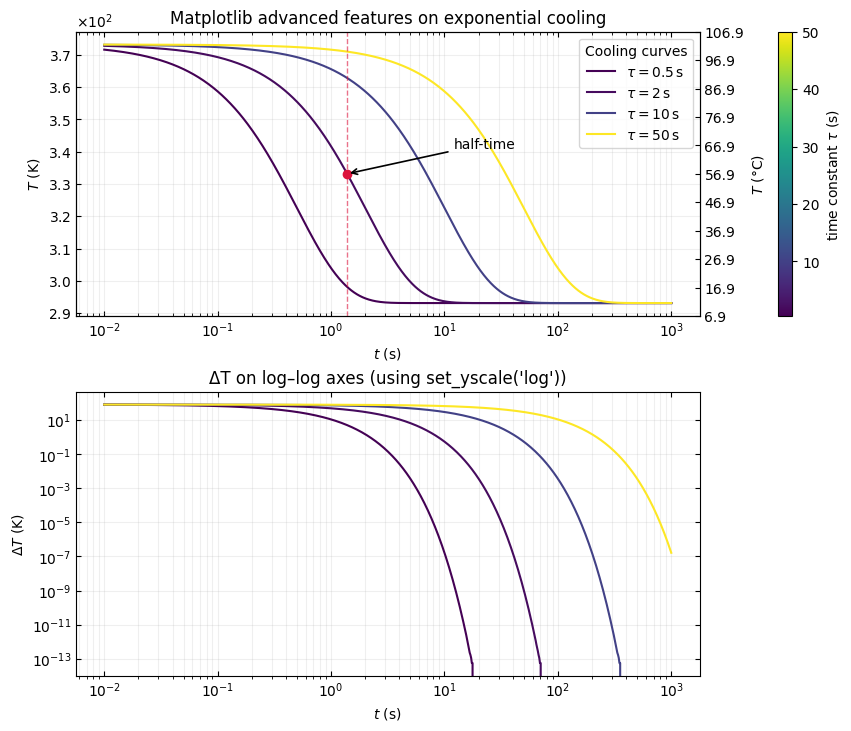

In [12]:
run_matplotlib_advanced()  # or run_matplotlib_advanced("advanced_matplotlib_demo.pdf")

In [13]:
import json
from jupyterquiz import display_quiz

quiz_json = \
'''
[
  {
    "question": "אם ברצוננו להציג נתונים על פני שלושה סדרי גודל בציר x, הבחירה הטובה היא:",
    "type": "many_choice",
    "answers": [
      {
        "answer": "<code>ax.set_xscale('linear')</code>",
        "correct": false,
        "feedback": "לא נכון — סולם ליניארי לא מתאים לפריסה על פני סדרי גודל רבים."
      },
      {
        "answer": "<code>ax.set_xscale('log')</code>",
        "correct": true,
        "feedback": "נכון! סולם לוגריתמי בציר x מציג היטב נתונים על פני כמה סדרי גודל."
      },
      {
        "answer": "<code>ax.set_yscale('log')</code>",
        "correct": false,
        "feedback": "זה משנה את סולם ציר ה-y, לא את ציר ה-x."
      },
      {
        "answer": "להשאיר ברירת מחדל",
        "correct": false,
        "feedback": "ברירת המחדל היא סולם ליניארי, שאינו מתאים כאן."
      }
    ]
  },
  {
    "question": "מה יוצר אובייקט צירים חדש בשיטה המומלצת?",
    "type": "many_choice",
    "answers": [
      {
        "answer": "<code>fig = plt.figure()</code>",
        "correct": false,
        "feedback": "זה יוצר Figure בלבד, ללא Axes ברירת מחדל."
      },
      {
        "answer": "<code>ax = plt.axes()</code>",
        "correct": false,
        "feedback": "אמנם יוצר Axes, אך השיטה המומלצת והנפוצה היא <code>plt.subplots()</code>."
      },
      {
        "answer": "<code>fig, ax = plt.subplots()</code>",
        "correct": true,
        "feedback": "נכון! זו הדרך המומלצת: מקבלים גם Figure וגם Axes מוכנים לשימוש."
      },
      {
        "answer": "<code>plt.plot(...)</code>",
        "correct": false,
        "feedback": "זו קריאה בסגנון pyplot; לא יוצרת במפורש אובייקטי Figure ו-Axes לעבודה מבוססת-אובייקטים."
      }
    ]
  },
  {
    "question": "להצגת שדה דו־ממדי (כמו טמפרטורה על רשת), מה מתאים?",
    "type": "many_choice",
    "answers": [
      {
        "answer": "<code>plot</code>",
        "correct": false,
        "feedback": "plot מתאים לעקומות/קווים, לא לשדות דו־ממדיים."
      },
      {
        "answer": "<code>scatter</code>",
        "correct": false,
        "feedback": "scatter מציג נקודות בדידות; לשדה רציף עדיפה הדמיה רסטרית."
      },
      {
        "answer": "<code>hist</code>",
        "correct": false,
        "feedback": "hist מציג התפלגות חד־ממדית (היסטוגרמה), לא מפה דו־ממדית."
      },
      {
        "answer": "<code>imshow</code>",
        "correct": true,
        "feedback": "נכון! imshow (או matshow) מתאימים להצגת שדות/מפות חום דו־ממדיות."
      }
    ]
  }
]
'''
myquiz = json.loads(quiz_json)
display_quiz(myquiz)


<IPython.core.display.Javascript object>